# Jupyter Notebook for Model Training

### Importing Required Libraries

In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
import json
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2  # Import L2 regularization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm  # Import tqdm for progress bar
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jamie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Jamie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jamie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Data Loading and Preprocessing

In [2]:
# Load intents
print("Loading intents...")
with open('data/intents_final.json', 'r', encoding='utf-8') as file:
    intents = json.load(file)

# Initialize data structures
words = []
classes = []
documents = []
ignore_words = ['?', '!', '.']

# Tokenize and process dataset
print("Processing data...")
for intent in intents['intents']:
    for pattern in intent['patterns']:  # Full dataset
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        documents.append((w, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

# Lemmatize, sort, and remove duplicates
print("Lemmatizing words...")
lemmatizer = WordNetLemmatizer()
words = sorted(set([lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]))
classes = sorted(set(classes))

print(f"Total unique words: {len(words)}")
print(f"Total classes: {len(classes)}")

Loading intents...
Processing data...
Lemmatizing words...
Total unique words: 581
Total classes: 80


### Training Data Creation

In [3]:
# Create training data
print("Creating training data...")
training = []
output_empty = [0] * len(classes)

for doc in tqdm(documents, desc="Processing documents"):
    bag = [1 if w in [lemmatizer.lemmatize(word.lower()) for word in doc[0]] else 0 for w in words]
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])

random.shuffle(training)
training = np.array(training, dtype=object)

# Split into training & testing sets
train_x, test_x, train_y, test_y = train_test_split(
    np.array(list(training[:, 0])), np.array(list(training[:, 1])), test_size=0.2, random_state=42
)

print(f"Training samples: {len(train_x)}, Testing samples: {len(test_x)}")

Creating training data...


Processing documents: 100%|██████████| 2043/2043 [00:23<00:00, 88.09it/s] 

Training samples: 1634, Testing samples: 409


### Model Creation and Compilation

In [4]:
# Compute class weights to handle imbalanced classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(np.argmax(train_y, axis=1)),
    y=np.argmax(train_y, axis=1)
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
num_classes = len(np.unique(np.argmax(train_y, axis=1)))  

# Build the model
print("Building model...")
model = Sequential([
    Dense(128, input_shape=(len(train_x[0]),), activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
model.summary()

Building model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               74496     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64

### Model Training

In [5]:
# Callbacks for early stopping and saving the best model
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('models/chatbot_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
print("Training model...")
history = model.fit(train_x, train_y, epochs=500, batch_size=32, verbose=1, 
                    validation_data=(test_x, test_y), class_weight=class_weight_dict, 
                    callbacks=[early_stop, checkpoint])

print("Model training completed.")


Training model...
Epoch 1/500
32/52 [=================>............] - ETA: 0s - loss: 5.1418 - accuracy: 0.0176     
Epoch 1: val_loss improved from inf to 4.37813, saving model to models\chatbot_model.keras
52/52 [==============================] - 1s 8ms/step - loss: 4.9676 - accuracy: 0.0165 - val_loss: 4.3781 - val_accuracy: 0.0196
Epoch 2/500
33/52 [==================>...........] - ETA: 0s - loss: 4.4408 - accuracy: 0.0379    
Epoch 2: val_loss improved from 4.37813 to 4.32710, saving model to models\chatbot_model.keras
52/52 [==============================] - 0s 4ms/step - loss: 4.4059 - accuracy: 0.0416 - val_loss: 4.3271 - val_accuracy: 0.0318
Epoch 3/500
33/52 [==================>...........] - ETA: 0s - loss: 4.0035 - accuracy: 0.0871
Epoch 3: val_loss improved from 4.32710 to 4.24134, saving model to models\chatbot_model.keras
52/52 [==============================] - 0s 4ms/step - loss: 4.0044 - accuracy: 0.0924 - val_loss: 4.2413 - val_accuracy: 0.0562
Epoch 4/500
34/52 [=

In [6]:
# Save words and classes to pickle files
pickle.dump(words, open('pkl/words.pkl', 'wb'))
pickle.dump(classes, open('pkl/classes.pkl', 'wb'))
print("Words and classes saved to pickle files.")

# Save training history
with open('models/training_history.json', 'w') as f:
    json.dump(history.history, f)
print("✅ Model training completed and saved!")

Words and classes saved to pickle files.
✅ Model training completed and saved!


### Model Evaluation

In [7]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)

# Print final training and validation metrics
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

Final Training Accuracy: 0.9455
Final Training Loss: 0.2194
Final Validation Accuracy: 0.9095
Final Validation Loss: 0.3777


### Graphs and Classification Report

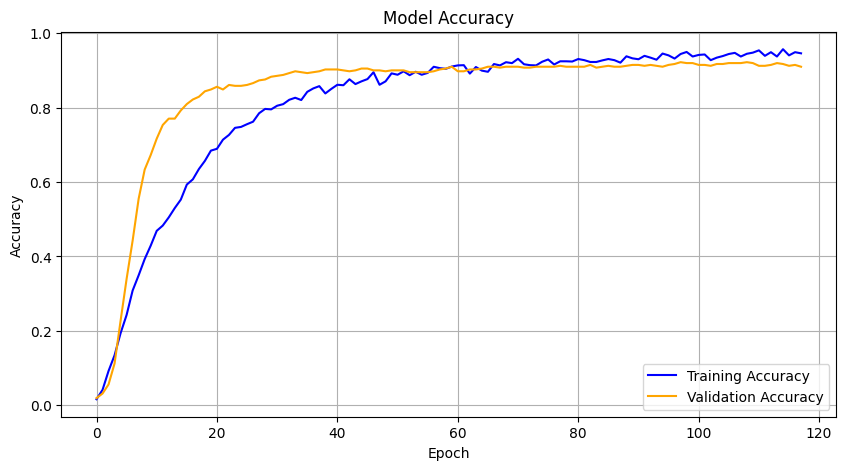

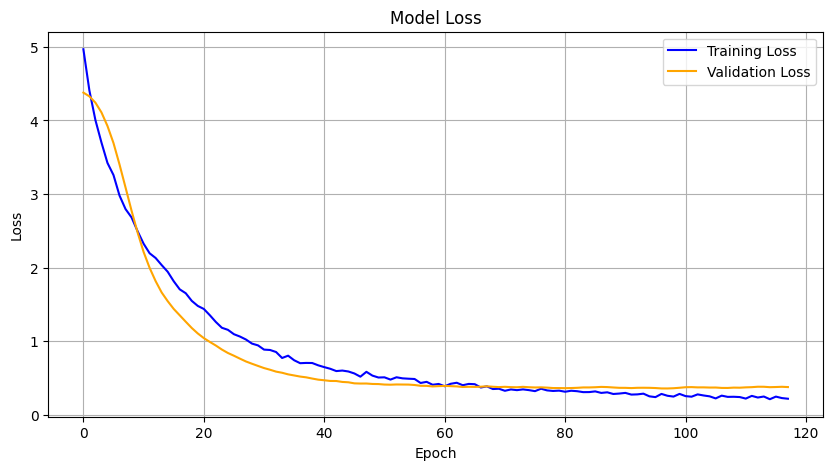

In [8]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

13/13 [==============================] - 0s 833us/step


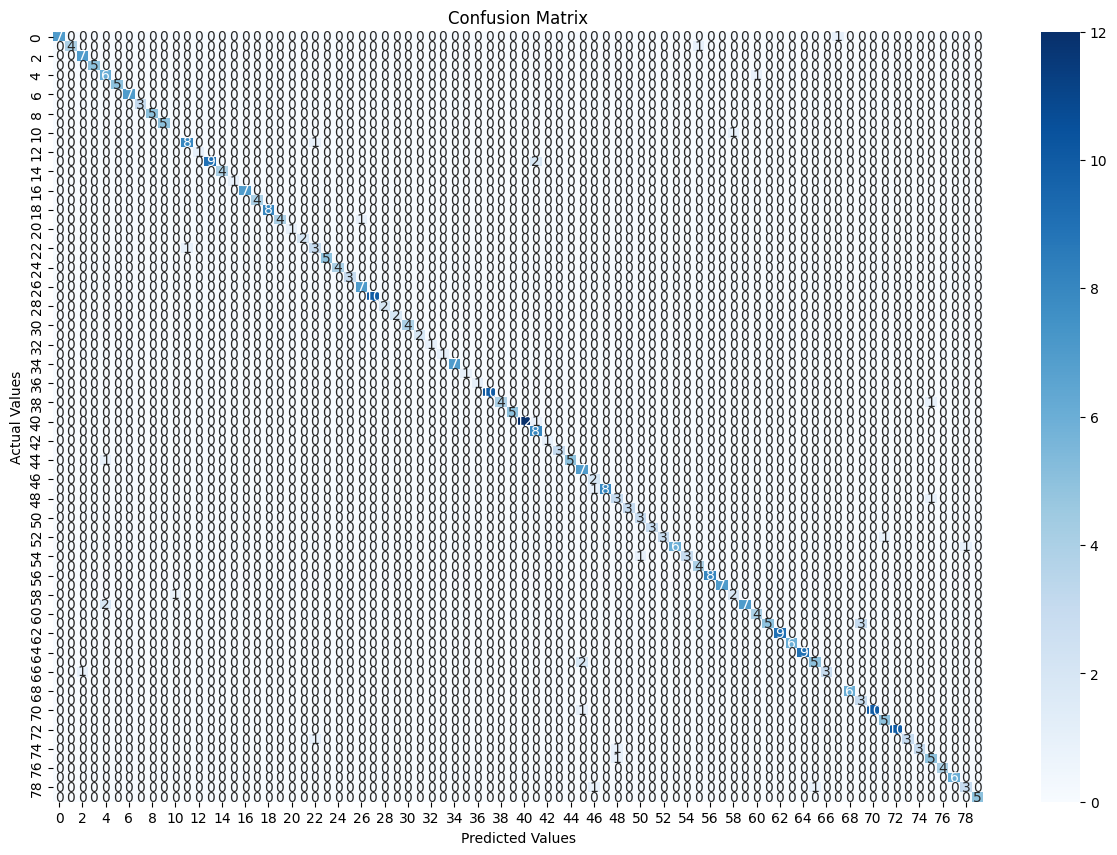

In [9]:
# Predict classes for the test set
y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_y, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Visualize confusion matrix using seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [10]:
# Classification report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes, labels=np.unique(y_true)))

Classification Report:
                     precision    recall  f1-score   support

              about       1.00      0.88      0.93         8
          afternoon       1.00      0.80      0.89         5
            anxious       0.88      1.00      0.93         7
                ask       1.00      1.00      1.00         5
             casual       0.67      0.86      0.75         7
           creation       1.00      1.00      1.00         5
              death       1.00      1.00      1.00         7
            default       1.00      1.00      1.00         3
          depressed       1.00      1.00      1.00         5
               done       1.00      1.00      1.00         5
            evening       0.00      0.00      0.00         1
             fact-1       0.89      0.89      0.89         9
            fact-10       1.00      1.00      1.00         1
            fact-11       1.00      0.82      0.90        11
            fact-12       1.00      1.00      1.00         4


c:\Users\Jamie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2642: UserWarning: labels size, 79, does not match size of target_names, 80
  warnings.warn(
